In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

## **Autoregression Models for Forecasting**

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems.

**Autoregression**

A regression model, such as linear regression, models an output value based on a linear combination of input values. For example:

$\ yhat = b_0 + (b_1\times X1)$

where: 

*yhat* is the prediction, 

*$b_0$* and *$b_1$* are coefficients found by optimizing the model on training data 
*X* is an input value. 

This technique can be used on time series where input variables are taken as observations at previous time steps, called lag variables. For example, we can predict the value for the next time step (t+1) given the observations at the current (t and previous t-1). As a regression model, this would look as follows:

$\ X(t+1) = b_0 + (b_1\times X(t))+ (b_2\times X(t -1))$

Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

**Autocorrelation**

An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. This relationship between variables is called correlation. If both variables change in the same direction (e.g. go up together or down together), this is called a positive correlation. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called negative correlation.

**We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling. Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. It is also called serial correlation because of the sequenced structure of time series data.**

The correlation statistics can also help to choose which lag variables will be useful in a model and which will not. **Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable.** This can be very useful when getting started on a new dataset.


**Quick Check for Autocorrelation**

There is a quick, visual check that we can do to see if there is an autocorrelation in our time series dataset. We can plot the observation at the current time step (t) with the observation at the previous time step (t-1) as a scatter plot. This could be done manually by first creating a lag version of the time series dataset and using a built-in scatter plot function in the Pandas library. But there is an easier way.

Pandas provides a built-in plot to do exactly this, called the lag plot() function.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Lag plot of the Minimum Daily Temperatures dataset.')

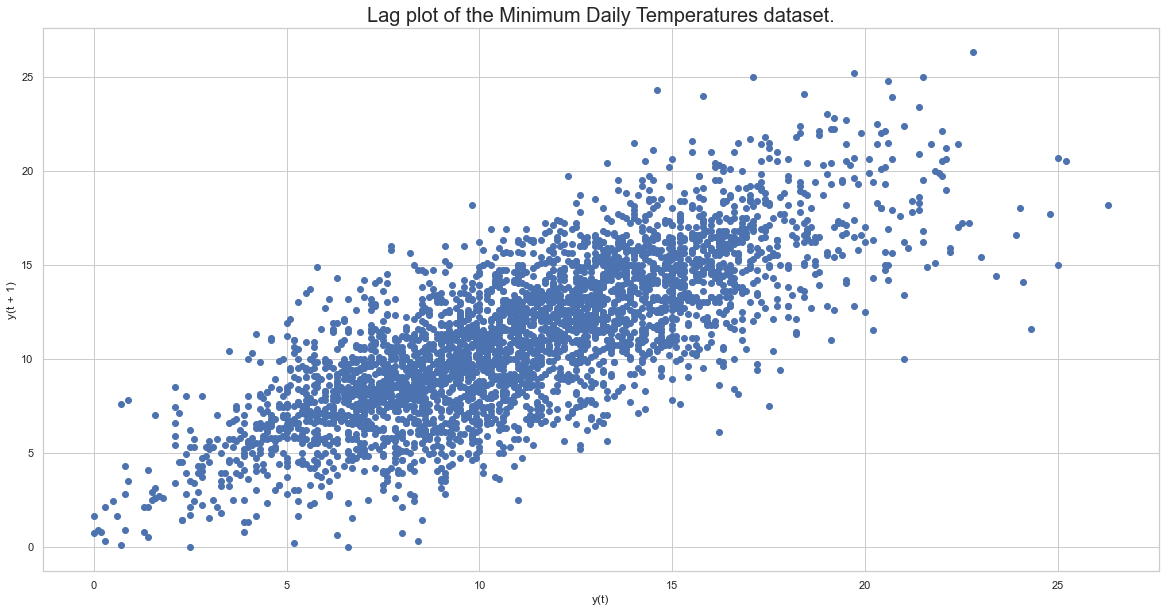

In [8]:
series = pd.read_csv("daily-minimum-temperatures.csv",index_col=0,header=0,squeeze=True, parse_dates=True)

# Create lagged plot of dataset

fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
pd.plotting.lag_plot(series)
ax.set_title("Lag plot of the Minimum Daily Temperatures dataset.", fontdict={'fontsize':20})

We can see a large ball of observations along a diagonal line of the plot. It clearly shows a relationship or some correlation. This process could be repeated for any other lagged observation, such as if we wanted to review the relationship with the last 7 days or with the same day last month or last year. Another quick check that we can do is to directly calculate the correlation between the observation and the lag variable.

We can use a statistical test like the Pearson's correlation coefficient. This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation and high values above 0.5 or below -0.5 showing high correlation. 

Correlation can be calculated easily using the corr() function on the DataFrame of the lagged dataset.

In [17]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
dataframe.head()

,t,t+1
0,NaN,20.7
1,20.7,17.9
2,17.9,18.8
3,18.8,14.6
4,14.6,15.8


In [18]:
result = dataframe.corr()
result

,t,t+1
t,1.00000,0.77487
t+1,0.77487,1.00000


<AxesSubplot:>

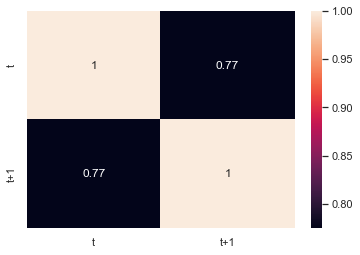

In [19]:
sns.heatmap(result, annot=True)

This is a good confirmation for the plot above. It shows a strong positive correlation (0.77) between the observation and the lag=1 value.

This is good for one-off checks, but tedious if we want to check a large number of lag variables in our time series. Next, we will look at a scaled-up version of this approach.

**Autocorrelation Plots**

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

Text(0.5, 1.0, 'Autocorrelation plot of the Minimum Daily Temperatures dataset with pandas.')

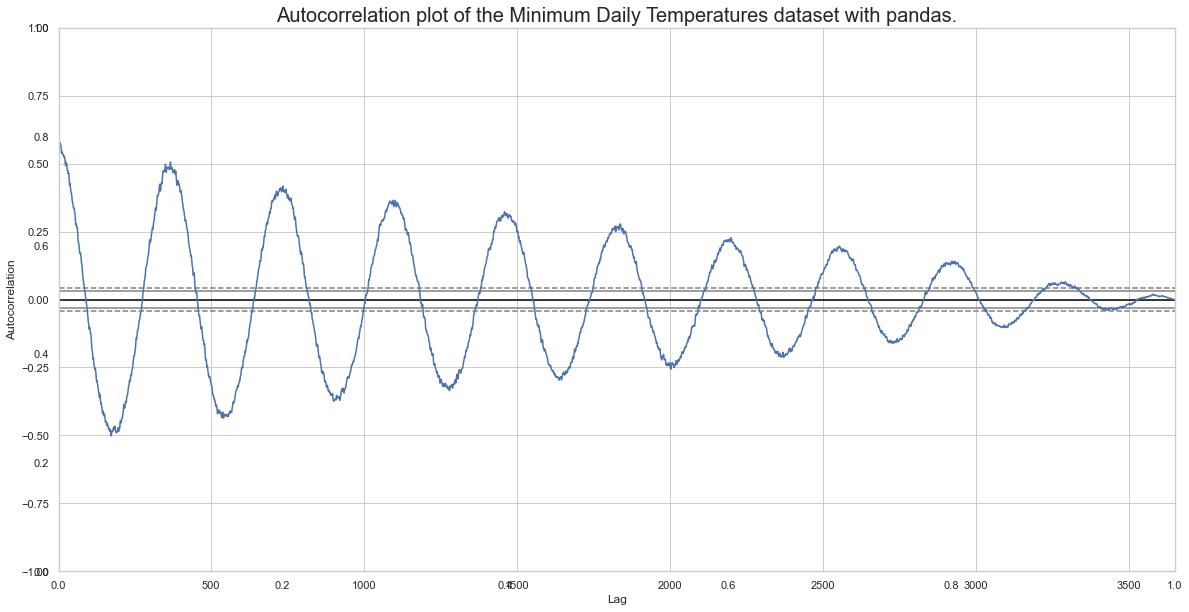

In [24]:
# autocorrelation plot of time series
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
pd.plotting.autocorrelation_plot(series)
plt.grid()
ax.set_title("Autocorrelation plot of the Minimum Daily Temperatures dataset with pandas.", fontdict={'fontsize':20})

Text(0.5, 1.0, 'Autocorrelation plot of the Minimum Daily Temperatures dataset with Statsmodels..')

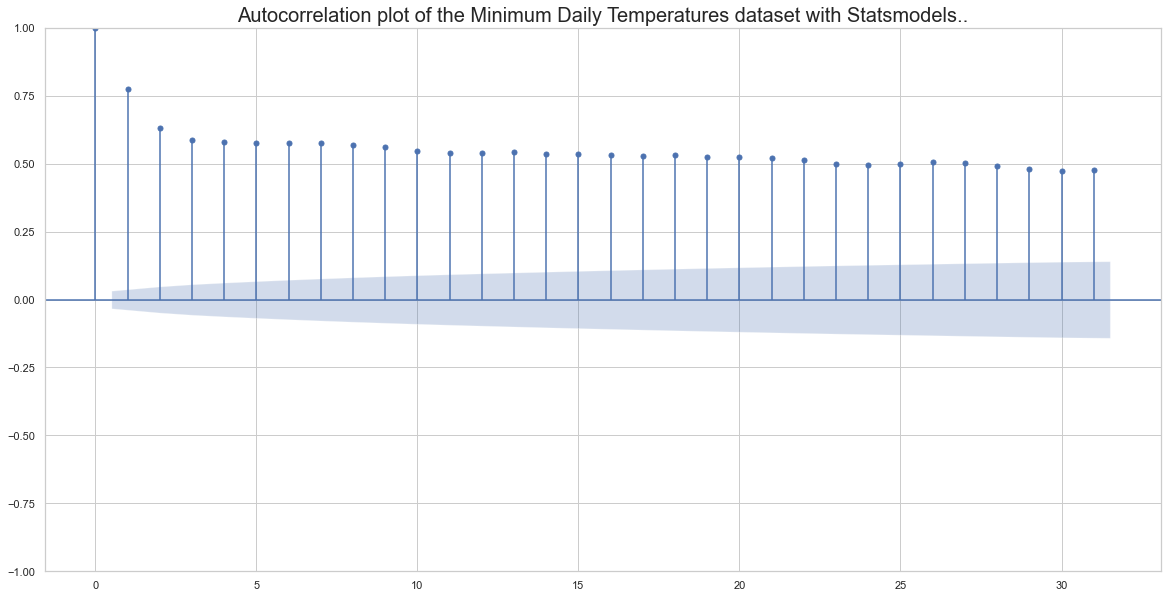

In [38]:
# The Statsmodels library also provides a version of the plot in the plot acf() function as a
# line plot.
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
plot_acf(series,lags=31,ax=ax)
ax.set_title("Autocorrelation plot of the Minimum Daily Temperatures dataset with Statsmodels..", fontdict={'fontsize':20})

Now that we know how to review the autocorrelation in our time series, let's look at modeling it with an autoregression. Before we do that, let's establish a baseline performance.

**Persistence Model**

Let's say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations. The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as unseen data that we wish to predict. The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day.

In [48]:
from sklearn.metrics import mean_squared_error
# We make use of previous calls for variables

# Split into train and test sets 
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistance model
def model_persistence(x):
    return x

# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

rmse = mean_squared_error(test_y,predictions,squared=False)
print(f"RMSE: {rmse}")

RMSE: 1.8500965225785224


Text(0.5, 1.0, 'Test (blue) and Predictions (red) plot, RMSE: 1.85')

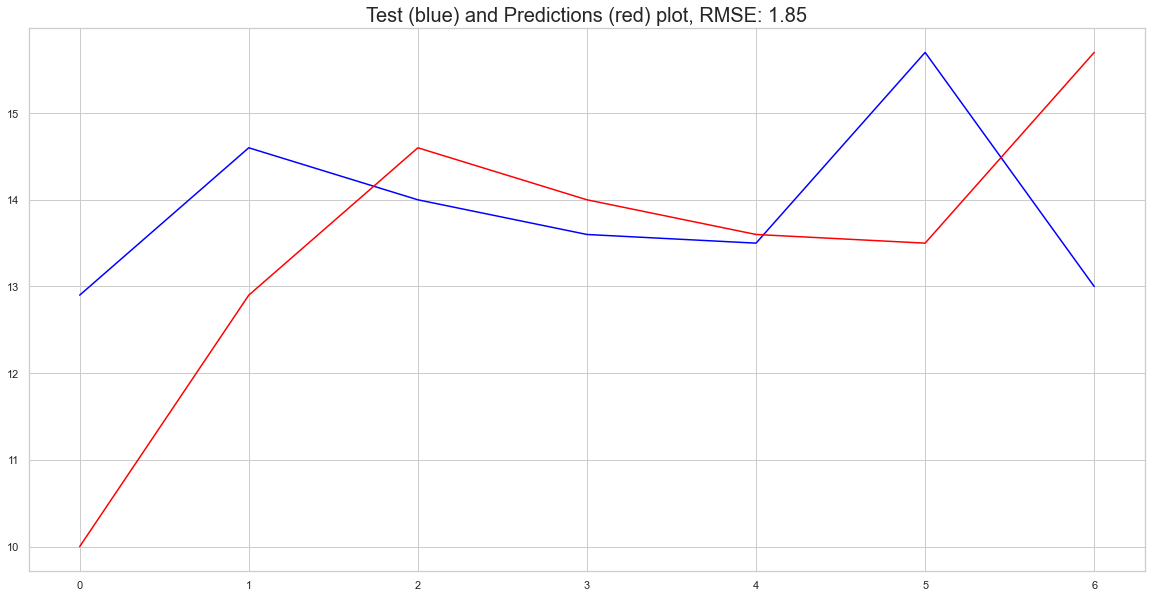

In [54]:
# Plotting the test and predictions 
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
sns.lineplot(data=test_y,color="blue")
sns.lineplot(data=predictions, color='red')
ax.set_title(f"Test (blue) and Predictions (red) plot, RMSE: {np.round(rmse,3)}",fontdict={'fontsize':20})

**Autoregression Model**

An autoregression model is a linear regression model that uses lagged variables as input variables. We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use. Alternately, the Statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class. 

We can use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an ARResult object. Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 7-day forecast, which is different from the persistence example above.

In [ ]:
# NotImplementedError: 
# AR has been removed from statsmodels and replaced with statsmodels.tsa.ar_model.AutoReg.

In [75]:
series.shape

(3650,)

In [72]:
# Split dataset
X = series.values 
train, test = X[1:len(X)-7], X[len(X)-7:]
X.shape

(3650,)

In [81]:
from statsmodels.tsa.ar_model import AutoReg
# train autoregression
model = AutoReg(train,lags=29)
model_fit = model.fit()
print(f"Lag: {len(model_fit.ar_lags)}")
print(f"Coefficicents: {model_fit.params}")

# print(len(X)) # 3650
# print(len(train)) # 3642
# print(len(test)) # 7
# print(len(train)+len(test)) # 3649
# print(len(train)+len(test)-1) # 3648


# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print(f"Predicted: {predictions[i]}, Expected: {test[i]}")

rmse = mean_squared_error(test,predictions,squared=False)
print("RMSE: {}".format(rmse))

Lag: 29
Coefficicents: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
Predicted: 11.871274847727818, Expected: 12.9
Predicted: 13.053794217229797, Expected: 14.6
Predicted: 13.532590951105096, Expected: 14.0
Predicted: 13.243126458186188, Expected: 13.6
Predicted: 13.091438030687947, Expected: 13.5
Predicted: 13.146988838852199, Expected: 15.7
Predicted: 13.176153455574177, Expected: 13.0
RMSE: 1.2253673861365078


Text(0.5, 1.0, 'Test (blue) and Predictions (red) plot, RMSE: 1.225')

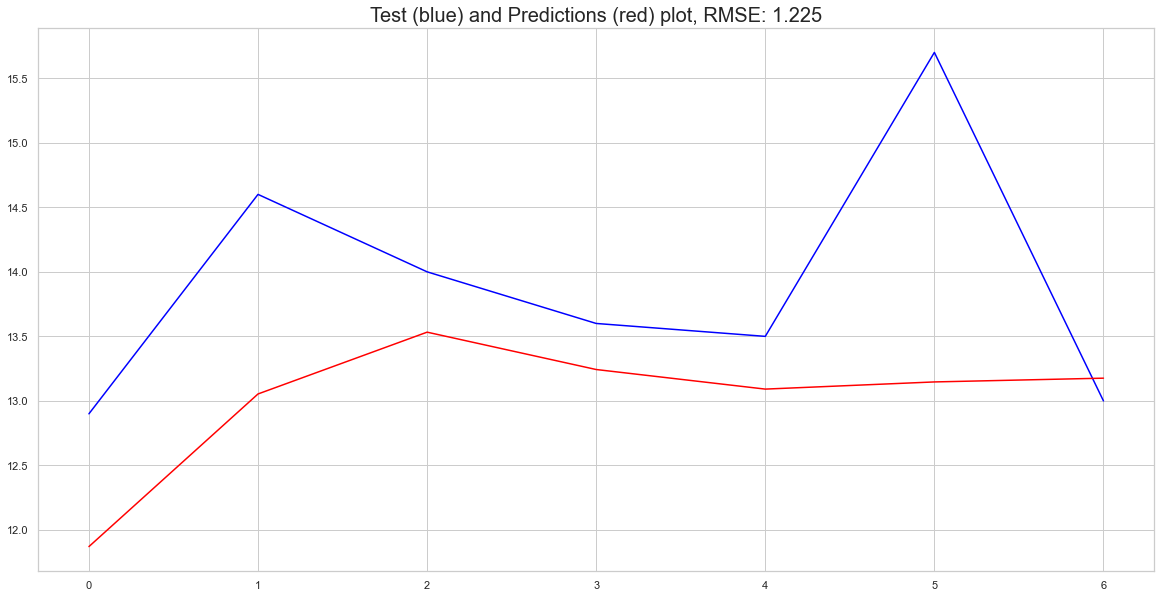

In [77]:
# Plotting the test and predictions 
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
sns.lineplot(data=test,color="blue")
sns.lineplot(data=predictions, color='red')
ax.set_title(f"Test (blue) and Predictions (red) plot, RMSE: {np.round(rmse,3)}",fontdict={'fontsize':20})

The Statsmodels API does not make it easy to update the model as new observations become available.
A solution would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts. The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t to t-n.

$\ yhat = b_0 + (b_1\times X_1) + (b_2\times  X_2)...(b_n\times X_n)$

In [82]:
len(train)-29

3613

In [92]:
# train autoregression
window  = 29
model = AutoReg(train,lags=29)
model_fit = model.fit()
coef = model_fit.params

# walk forward over times steps in test
history = train[len(train)-window:] # 3613
# print(history)
history = [history[i] for i in range(len(history))]
# print(history)
# print(len(history))

predictions = []
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat+=coef[d+1] * lag[window-d-1] # 29 values from 0-28
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print(f"Predicted: {yhat}, Expected: {obs}")
rmse = mean_squared_error(test,predictions,squared=False)
print("RMSE: {}".format(rmse))
# print(lag)

Predicted: 11.87127484772782, Expected: 12.9
Predicted: 13.659296925615912, Expected: 14.6
Predicted: 14.34924559427322, Expected: 14.0
Predicted: 13.427453782606074, Expected: 13.6
Predicted: 13.37487745878147, Expected: 13.5
Predicted: 13.479990772376246, Expected: 15.7
Predicted: 14.76514638091344, Expected: 13.0
RMSE: 1.2044430107159023


Text(0.5, 1.0, 'Test (blue) and Predictions (red) plot, RMSE: 1.204')

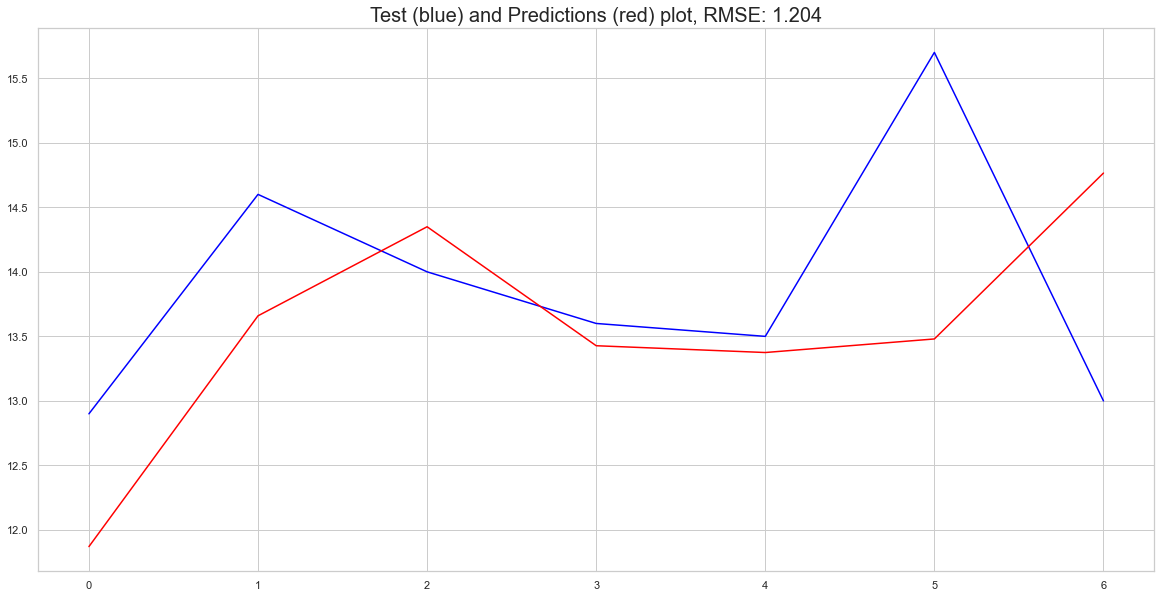

In [93]:
# Plotting the test and predictions 
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
sns.lineplot(data=test,color="blue")
sns.lineplot(data=predictions, color='red')
ax.set_title(f"Test (blue) and Predictions (red) plot, RMSE: {np.round(rmse,3)}",fontdict={'fontsize':20})